In [1]:
import xarray as xr #work with arrays
import numpy as np #additional functions for arrays
import pandas as pd #Open csv files
import matplotlib.pyplot as plt #plotting (used as checks to make sure everything works)
import csv #write csv

#Function that takes the weighted mean of the given area
def mean_2D(var, weights):
    # assumes 2D field as var input

    # make sure masking is correct, otherwise we get nans
    var = np.ma.masked_invalid(var)
    weights =  np.ma.masked_invalid(weights)
    # resulting variable should have dimensions of depth and time (x)
    ave = np.zeros(var.shape[0])

    # loop over time
    #for t in np.arange(var.shape[0]):
    ave = np.ma.average(var[:,:], weights = weights)
    return ave

#File containing the country mask
country_masks = xr.open_dataset('/glade/work/vgarza/nuclear_ocean/gadm0_regrid.mask.nc4')

#Cell area weights derived from the country masks
weights = xr.open_dataset('/glade/work/vgarza/nuclear_ocean/gadm0_regrid.weights.nc4')

#CSV file containing the nation id and the nation name
nationIDname =pd.read_csv('/glade/work/vgarza/nuclear_ocean/nationIDname.csv')

In [2]:
country_masks

<xarray.Dataset>
Dimensions:  (lon: 144, lat: 96)
Coordinates:
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float64 -89.06 -87.19 -85.31 -83.44 ... 85.31 87.19 89.06
Data variables:
    gadm0    (lat, lon) float64 ...
Attributes:
    CDI:           Climate Data Interface version 2.3.0 (https://mpimet.mpg.d...
    Conventions:   CF-1.6
    person_notes:  Joshua Elliott
    history:       Thu Mar 06 09:52:43 2025: cdo remapbil,r144x96 ./gadm0.mas...
    CDO:           Climate Data Operators version 2.3.0 (https://mpimet.mpg.d...

In [3]:
weights

<xarray.Dataset>
Dimensions:    (lon: 144, lat: 96)
Coordinates:
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat        (lat) float64 -89.06 -87.19 -85.31 -83.44 ... 85.31 87.19 89.06
Data variables:
    cell_area  (lat, lon) float64 ...
Attributes:
    CDI:          Climate Data Interface version 2.3.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Mar 06 10:06:02 2025: cdo gridarea ./gadm0_regrid.mask....
    CDO:          Climate Data Operators version 2.3.0 (https://mpimet.mpg.de...

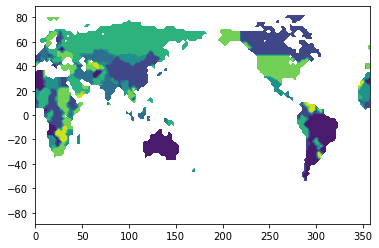

In [4]:
plt.contourf(country_masks['lon'],country_masks['lat'],country_masks['gadm0'])

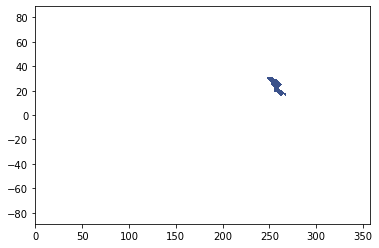

In [5]:
#A quick check to see if the method for isolating a country works
one = np.zeros([96,144])
one[:] = np.nan
one[(country_masks['gadm0'])== 145] = 0

plt.contourf(country_masks['lon'],country_masks['lat'],one)

## Change variables on the next cell:

### Control:
'/glade/work/vgarza/nuclear_ocean/scratch/alpine/joco6825/dwinstead_data/nw_cntrl_03/nw_cntrl_03.cam.h0.*.nc'
Years: 1 - 21
### nw_targets_04
'/glade/work/vgarza/nuclear_ocean/scratch/alpine/joco6825/dwinstead_data/nw_targets_04/nw_targets_04.cam.h0.*.nc'
Years: 5 - 19

### nw_targets_05
'/glade/work/vgarza/nuclear_ocean/scratch/alpine/joco6825/dwinstead_data/nw_targets_05/nw_targets_05.cam.h0.*.nc'
Years: 5 - 19

### nw_ur_150
'/glade/work/vgarza/nuclear_ocean/scratch/alpine/joco6825/dwinstead_data/nw_ur_150_07/nw_ur_150_07.cam.h0.*.nc'
Years: 5 - 34

In [10]:
#The dataset you would like to use
dataset =  xr.open_mfdataset('/glade/work/vgarza/nuclear_ocean/scratch/alpine/joco6825/dwinstead_data/nw_ur_150_07/nw_ur_150_07.cam.h0.*.nc')

#A list of the variables within the dataset to calculate country mean to
variables = ['TS','PRECC']

#The directory you would like to save the file to
outpath = '/glade/work/vgarza/nuclear_ocean/output/'
#A list of file names to save the files in
outfile_names = ['nw_ur_150_07.TS.country_mean.csv', 'nw_ur_150_07.PRECC.country_mean.csv']

#Start year and end year
startYear, endYear = 5,34

In [13]:
dataset['TS']

<xarray.DataArray 'TS' (time: 360, lat: 96, lon: 144)>
dask.array<concatenate, shape=(360, 96, 144), dtype=float32, chunksize=(1, 96, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) object 0005-02-01 00:00:00 ... 0035-01-01 00:00:00
Attributes:
    units:         K
    long_name:     Surface temperature (radiative)
    cell_methods:  time: mean

In [14]:
dataset['PRECC']

<xarray.DataArray 'PRECC' (time: 360, lat: 96, lon: 144)>
dask.array<concatenate, shape=(360, 96, 144), dtype=float32, chunksize=(1, 96, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) object 0005-02-01 00:00:00 ... 0035-01-01 00:00:00
Attributes:
    units:         m/s
    long_name:     Convective precipitation rate (liq + ice)
    cell_methods:  time: mean

In [11]:
data = []

for variable, out in zip(variables, outfile_names):
    index = 0


    #Organize the file structure 
    outfile = outpath + out
    file = open(outfile, 'w')
    writer = csv.writer(file)

    row = ['ID','Nation']

    for year in range(startYear,endYear+1):
        for month in range(1,12+1):
            row.append(str(year).zfill(4) + ' - ' + str(month).zfill(2))
    writer.writerow(row)

    #Loop through each nation
    for nation_id in (nationIDname['GGCMI-nation-ID'][:]):

        #Isolate get the mask for the nation and add the country row to the csv
        print(nationIDname['crop model output'][index])
        nation_mask = np.zeros([96,144])
        nation_mask[:] = np.nan
        nation_mask[(country_masks['gadm0'])== nation_id] = 0

        row = [nation_id,nationIDname['crop model output'][index]]

        #Loop through time
        for time in range(0,(endYear - startYear) * 12):
                #Isolate the country and calculate the weighted mean
                country_mean = dataset[variable][time,:,:] - nation_mask
                var = (mean_2D(country_mean, weights['cell_area']))

                #If everythin is zeros, save na
                if type(var) == np.ma.core.MaskedConstant:
                #    print("nan")
                    var = str('NA')
                #save variable to csv file
                row.append(var)
            
        writer.writerow(row)
        #plt.contourf(country_masks['lon'],country_masks['lat'],nation_mask)
        #plt.show()
        #Go to the next country
        index +=1

    file.close()


Afghanistan
Albania
Algeria
American Samoa
Angola
Antigua and Barbuda
Argentina
Armenia
Aruba
Australia
Austria
Azerbaijan
Bahamas
Bahrain
Bangladesh
Barbados
Belarus
Belgium
Belize
Benin
Bermuda
Bhutan
Bolivia
Bonaire, Saint Eustatius and Saba
Bosnia and Herzegovina
Botswana
Bouvet Island
Brazil
British Indian Ocean Territory
British Virgin Islands
Brunei
Bulgaria
Burkina Faso
Burundi
Cambodia
Cameroon
Canada
Cape Verde
Caspian Sea
Cayman Islands
Central African Republic
Chad
Chile
China
Christmas Island
Cocos Islands
Colombia
Comoros
Cook Islands
Costa Rica
C??te d'Ivoire
Croatia
Cuba
Cura??ao
Cyprus
Czech Republic
Democratic Republic of the Congo
Denmark
Djibouti
Dominica
Dominican Republic
East Timor
Ecuador
Egypt
El Salvador
Equatorial Guinea
Eritrea
Estonia
Ethiopia
Falkland Islands
Faroe Islands
Fiji
Finland
France
French Guiana
French Polynesia
French Southern Territories
Gabon
Gambia
Georgia
Germany
Ghana
Greece
Grenada
Guadeloupe
Guam
Guatemala
Guernsey
Guinea
Guinea-Bissau
G

In [12]:
!pwd

/glade/u/home/vgarza
